In [104]:
#%reset
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np
import os 
from matplotlib.patches import Polygon
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from eli5.sklearn import PermutationImportance
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
#from Functions_AMR_gonorrhea import effective_unnecessary_threshold, get_best_hyperparameters, get_best_features, get_test_train_data, get_feature_effects, f1_mcc_score_threshold
hfont = {'fontname':'Helvetica'}
import pickle
## read data 
CIP_data_no_drop = pd.read_csv("CIP_data_encode_prev_not_dropped.csv")
print(CIP_data_no_drop.columns)

Index(['Unnamed: 0.1', 'Unnamed: 0', 'CLINIC', 'YEAR', 'GENDERSP',
       'Susceptible', 'REGION', 'MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing',
       'Midwest', 'Northeast', 'Southeast', 'Southwest', 'West', 'PREV_REGION',
       'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75',
       'Trend_N_greater_75'],
      dtype='object')


In [108]:


################################ Get hyperparameters and best features for each model  ###########################
#### Loop set up 
threshold_seq = np.linspace(0,1,101)
test_years = [2005, 2006, 2007, 2008, 2009, 2010]  #np.array(range(2005, 2011))
oversample = RandomOverSampler(sampling_strategy = 'minority',random_state=42) #need for neural network and random forest
model_types = ["Logistic_regression",  "Random_forest", "Neural_network"]
i = 0

# logistic regression - random initial parameters
model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')
# random forest - random initial parameters
model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)
# neural network - random parameters
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =1.291549665014884, random_state=10, learning_rate = 'adaptive' )
unfitted_models = [model_lr, model_rf, model_nn]

### Hyperparameter tuning
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations
# logistic regression 
best_hyperparameters_by_year = {}

space_lr = dict()
space_lr['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space_lr['penalty'] = ['l1', 'l2']
space_lr['C'] = np.arange(0, 100, .01)
best_hyperparameters_by_year_lr = {}
# random forest 
space_rf = dict()
space_rf['n_estimators'] = np.arange(100, 201, 1)
space_rf['max_depth'] = np.arange(1, 200, 1)
space_rf['min_samples_split'] = np.arange(1, 25, 1)
space_rf['min_samples_leaf'] = np.arange(1, 25, 1)
best_hyperparameters_by_year_rf = {}

# neural network 
space_nn = dict()
space_nn['solver'] = ['lbfgs', 'sgd', 'adam']
space_nn['activation'] = ['tanh', 'relu']
space_nn['alpha'] = np.logspace(-1, 1, 10)
space_nn['learning_rate'] = ['constant','adaptive']
space_nn['hidden_layer_sizes'] = [(4,), (6,), (8,), (10,), (12,), (13,), (14,)]

space = [space_lr, space_rf, space_nn]
best_hyperparameters_by_year = [best_hyperparameters_by_year_lr, best_hyperparameters_by_year_rf,best_hyperparameters_by_year_nn]

### Feature Engineering
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION',  'Count_Exceeds_75', 'Trend_N_greater_75']
best_features_by_year_lr = {}
best_features_by_year_rf = {}
best_features_by_year_nn = {}
best_features_by_year = [best_features_by_year_lr, best_features_by_year_rf, best_features_by_year_nn]

imporances_all_models = pd.DataFrame(0, index = feature_names, columns=np.arange(len(test_years)*3))
indices_for_importance = [6,12,0] ## need to be in correct order 
imporances_all_models_sd = pd.DataFrame(0, index = feature_names, columns=np.arange(len(test_years)*3))


oversample = RandomOverSampler(sampling_strategy='minority', random_state=10)

def get_test_train_data(CIP_data_no_drop, year, feature_names, years_train, model_type):

    train_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin(years_train)]
    X_train = train_data[
        feature_names
    ]  # need to consider all columns BEFORE feature engineering
    y_train = 1 - train_data["Susceptible"]
    # test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin([year])]
    X_test = test_data[feature_names]
    y_test = 1 - test_data["Susceptible"]
    cipro_R_prev = y_test.sum() / len(y_test)
    if (model_type == 1) | (model_type == 2):
        X_train, y_train = oversample.fit_resample(X_train, y_train)
        # X_test, y_test = oversample.fit_resample(X_test, y_test)
        print("Oversample")
    return (test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev)

def get_feature_effects(all_features, important_features, model_fit, X_train, y_train):
    PI = permutation_importance(
        model_fit, X_train, y_train, n_repeats=10, random_state=0
    )
    feature_importances = []
    for feature in all_features:
        if feature in important_features:
            feature_importances.append(PI.importances_mean[important_features.index(feature)])
        else:
            feature_importances.append(0)
    return feature_importances

def get_best_features(feature_names, model_fit, X_train, y_train):
    PI = permutation_importance(
        model_fit, X_train, y_train, n_repeats=10, random_state=0
    )
    important_features = []
    for q in PI.importances_mean.argsort()[::-1]:
        if PI.importances_mean[q] - PI.importances_std[q] >0:
            important_features.append(
                feature_names[q]
            )  # works cos they are in same order as the x columns
    return important_features

def get_feature_effects_sd(feature_names, important_features,model_fit, X_train, y_train):
    PI = permutation_importance(
        model_fit, X_train, y_train, n_repeats=10, random_state=42
    )

    return PI.importances_std

def get_best_hyperparameters(model, cv, space, X_train, y_train, sample_weights):
    search = RandomizedSearchCV(
        model, space, scoring="roc_auc", n_iter=20, n_jobs=-1, cv=cv, random_state=1
    )
    result = search.fit(X_train, y_train, sample_weight = sample_weights)
    return result.best_params_

### ROC by year 
ROC_by_year_rf = {}
ROC_by_year_lr = {}
ROC_by_year_nn = {}

ROC_by_year = [ROC_by_year_lr, ROC_by_year_rf, ROC_by_year_nn]


def get_test_train_data(CIP_data_no_drop, year, feature_names, years_train, model_type):
    feature_names_with_weight = feature_names.copy()
    feature_names_with_weight.extend(['weight'])
    train_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin(years_train)]
    X_train = train_data[feature_names_with_weight]  # need to consider all columns BEFORE feature engineering
    y_train = 1 - train_data["Susceptible"]
    # test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin([year])]
    X_test = test_data[feature_names_with_weight]
    y_test = 1 - test_data["Susceptible"]
    cipro_R_prev = y_test.sum() / len(y_test)

    if (model_type == 1) | (model_type == 2):
        X_train, y_train = oversample.fit_resample(X_train, y_train)
        # X_test, y_test = oversample.fit_resample(X_test, y_test)
        print("Oversample")
    weights_train = X_train["weight"]
    X_train  = X_train.drop("weight", axis = 1)
    X_test = X_test.drop("weight", axis = 1)

    return (test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train)

In [112]:
# Just LR
model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2']
space['C'] = np.arange(0, 100, .01)
i = 0
for year in test_years: 
    print(year)
    model_type = 0
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 

    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

 
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names, years_train = years_train, model_type = model_type)
    best_hyperparameters1 = get_best_hyperparameters(model_lr, cv, space, X_train, y_train, weights_train)
    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=5000, solver = best_hyperparameters1['solver'], C = best_hyperparameters1['C'], penalty = best_hyperparameters1['penalty'])
    
    print("Hyperparameters1")
    ## fit model w/hyperparameters 
    model_fit = model_lr.fit(X_train, y_train, sample_weight = weights_train)

    ## now also need to do feature engineering
    important_features = get_best_features(feature_names, model_fit, X_train, y_train)
    best_features_by_year[model_type].__setitem__(year, important_features) 
    imporances_all_models[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, important_features, model_fit, X_train, y_train) #want it to be the correct block for each model
    imporances_all_models_sd[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, important_features, model_fit, X_train, y_train) #want it to be the correct block for each model

    # get new test/train data and hyperparameter tuning round 2 

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features, years_train = years_train, model_type = model_type)
    
    best_hyperparameters2 = get_best_hyperparameters(model_lr, cv, space, X_train, y_train, weights_train)
    best_hyperparameters_by_year[model_type].__setitem__(year, best_hyperparameters2) 


    ## fit model w/hyperparameters 
    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=5000, solver = best_hyperparameters2['solver'], C = best_hyperparameters2['C'], penalty = best_hyperparameters2['penalty'])

    model_fit_train = model_lr.fit(X_train, y_train, sample_weight = weights_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    ROC= metrics.roc_auc_score(y_test, y_predict_test)
    ROC_by_year[model_type].__setitem__(year, ROC)
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)
    print(ROC)
    i += 1

2005


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

Hyperparameters1


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

0.7301280825377211
2006


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

Hyperparameters1


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

0.688908716090679
2007


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

Hyperparameters1


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

0.6859769375400482
2008


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

Hyperparameters1


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

0.706340000521553
2009


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

Hyperparameters1


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

0.6455044050644695
2010


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

Hyperparameters1


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

0.6526505174435401


In [114]:
print("RF:", ROC_by_year)
print("RF:",best_hyperparameters_by_year)
print("RF:",best_features_by_year)

RF: [{2005: 0.7301280825377211, 2006: 0.688908716090679, 2007: 0.6859769375400482, 2008: 0.706340000521553, 2009: 0.6455044050644695, 2010: 0.6526505174435401}, {}, {}]
RF: [{2005: {'solver': 'liblinear', 'penalty': 'l2', 'C': 12.91}, 2006: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 55.0}, 2007: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 20.28}, 2008: {'solver': 'liblinear', 'penalty': 'l1', 'C': 35.730000000000004}, 2009: {'solver': 'liblinear', 'penalty': 'l1', 'C': 81.83}, 2010: {'solver': 'liblinear', 'penalty': 'l1', 'C': 54.85}}, {}, {}]
RF: [{2005: ['West', 'Southwest', 'Northeast', 'MSW', 'MSM', 'Trend_N_greater_75'], 2006: ['West', 'Southwest'], 2007: ['MSW', 'West', 'Oth/Unk/Missing', 'Southeast', 'Northeast'], 2008: ['West', 'MSW', 'PREV_CLINIC', 'Southeast', 'Northeast', 'Oth/Unk/Missing'], 2009: ['West', 'PREV_CLINIC', 'MSM', 'MSW', 'DELTA_REGION', 'PREV_REGION', 'Southeast', 'Northeast', 'Oth/Unk/Missing', 'Trend_N_greater_75', 'Count_Exceeds_75'], 2010: ['MSM', 'PREV_C

In [ ]:
ROC_by_year = [{2005: 0.7301280825377211, 2006: 0.7118669195200309, 2007: 0.6859769375400482, 2008: 0.6768972801001382, 2009: 0.6455044050644695, 2010: 0.6601163469109158}, {}, {}]
best_hyperparameters_by_year =[{2005: {'solver': 'liblinear', 'penalty': 'l2', 'C': 12.91}, 2006: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2007: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 55.0}, 2008: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 20.28}, 2009: {'solver': 'liblinear', 'penalty': 'l1', 'C': 81.83}, 2010: {'solver': 'liblinear', 'penalty': 'l1', 'C': 81.83}}, {2005: {'solver': 'liblinear', 'penalty': 'l2', 'C': 12.91}, 2006: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2007: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 55.0}, 2008: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 20.28}, 2009: {'solver': 'liblinear', 'penalty': 'l1', 'C': 81.83}, 2010: {'solver': 'liblinear', 'penalty': 'l1', 'C': 81.83}}, {}]
best_features_by_year =[{2005: ['West', 'Southwest', 'Northeast', 'MSW', 'MSM', 'Trend_N_greater_75'], 2006: ['West', 'Southwest', 'Southeast', 'MSW'], 2007: ['MSW', 'Oth/Unk/Missing', 'West'], 2008: ['West', 'MSW', 'Oth/Unk/Missing', 'Trend_N_greater_75', 'Northeast'], 2009: ['West', 'PREV_CLINIC', 'MSW', 'MSM', 'DELTA_REGION', 'PREV_REGION', 'Southeast', 'Northeast', 'Oth/Unk/Missing', 'Trend_N_greater_75'], 2010: ['MSM', 'PREV_CLINIC', 'DELTA_REGION', 'West', 'MSW', 'PREV_REGION', 'MSMW', 'Southeast', 'Southwest', 'Count_Exceeds_75']}, {}, {}]

In [115]:
imporances_all_models.to_csv('imporances_all_models_with_weights_and_count_features.csv')

In [116]:
## Just RF
model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)

space = dict()
space['n_estimators'] = np.arange(1, 201, 1)
space['max_depth'] = np.arange(1, 200, 1)
space['min_samples_split'] = np.arange(1, 100, 1)
space['min_samples_leaf'] = np.arange(1, 100, 1)
test_years = [2005, 2006, 2007, 2008, 2009, 2010]  #np.array(range(2005, 2011))

i = 0
for year in test_years: 
    print(year)
    model_type = 1
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

 
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names, years_train = years_train, model_type = model_type)

    ## before fitting the model, do hyperparameter tuning 
    best_hyperparameters1 = get_best_hyperparameters(model_rf, cv, space, X_train, y_train, weights_train)
    model_rf = RandomForestClassifier(n_estimators = best_hyperparameters1['n_estimators'], min_samples_split = best_hyperparameters1['min_samples_split'], min_samples_leaf=best_hyperparameters1['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters1['max_depth'], random_state = 10)
    
     
    ## fit model w/hyperparameters 
    model_fit = model_rf.fit(X_train, y_train, sample_weight = weights_train)

    ## now also need to do feature engineering
    important_features = get_best_features(feature_names, model_fit, X_train, y_train)
    best_features_by_year[model_type].__setitem__(year, important_features) 
    imporances_all_models[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, important_features, model_fit, X_train, y_train) #want it to be the correct block for each model
    imporances_all_models_sd[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, important_features, model_fit, X_train, y_train) #want it to be the correct block for each model

    # get new test/train data and hyperparameter tuning round 2 

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features, years_train = years_train, model_type = model_type)
    
    best_hyperparameters2 = get_best_hyperparameters(model_rf, cv, space, X_train, y_train, weights_train)
    best_hyperparameters_by_year[model_type].__setitem__(year, best_hyperparameters2) 



    ## fit model w/hyperparameters 
    model_rf = RandomForestClassifier(n_estimators = best_hyperparameters2['n_estimators'], min_samples_split = best_hyperparameters2['min_samples_split'], min_samples_leaf=best_hyperparameters2['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters2['max_depth'], random_state = 10)

    model_fit_train = model_rf.fit(X_train, y_train, sample_weight = weights_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    ROC= metrics.roc_auc_score(y_test, y_predict_test)
    ROC_by_year[model_type].__setitem__(year, ROC)
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1

2005
Oversample
Oversample
2006
Oversample
Oversample
2007
Oversample
Oversample
2008
Oversample
Oversample
2009
Oversample
Oversample
2010
Oversample
Oversample


In [120]:
print("RF:",ROC_by_year)
print("RF:",best_hyperparameters_by_year)
print("RF:",best_features_by_year)
imporances_all_models.to_csv('imporances_all_models_with_weights_and_count_features.csv', index = False)

RF: [{2005: 0.7301280825377211, 2006: 0.688908716090679, 2007: 0.6859769375400482, 2008: 0.706340000521553, 2009: 0.6455044050644695, 2010: 0.6526505174435401}, {2005: 0.7422861470301229, 2006: 0.716008241481748, 2007: 0.6904656174878919, 2008: 0.6891381333611495, 2009: 0.6675168178659392, 2010: 0.6670052565692955}, {}]
RF: [{2005: {'solver': 'liblinear', 'penalty': 'l2', 'C': 12.91}, 2006: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 55.0}, 2007: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 20.28}, 2008: {'solver': 'liblinear', 'penalty': 'l1', 'C': 35.730000000000004}, 2009: {'solver': 'liblinear', 'penalty': 'l1', 'C': 81.83}, 2010: {'solver': 'liblinear', 'penalty': 'l1', 'C': 54.85}}, {2005: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2006: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2007: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2008: {'n_estimators

In [121]:
ROC_by_year = [{2005: 0.7301280825377211, 2006: 0.688908716090679, 2007: 0.6859769375400482, 2008: 0.706340000521553, 2009: 0.6455044050644695, 2010: 0.6526505174435401}, {2005: 0.7422861470301229, 2006: 0.716008241481748, 2007: 0.6904656174878919, 2008: 0.6891381333611495, 2009: 0.6675168178659392, 2010: 0.6670052565692955}, {}]
best_hyperparameters_by_year =  [{2005: {'solver': 'liblinear', 'penalty': 'l2', 'C': 12.91}, 2006: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 55.0}, 2007: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 20.28}, 2008: {'solver': 'liblinear', 'penalty': 'l1', 'C': 35.730000000000004}, 2009: {'solver': 'liblinear', 'penalty': 'l1', 'C': 81.83}, 2010: {'solver': 'liblinear', 'penalty': 'l1', 'C': 54.85}}, {2005: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2006: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2007: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2008: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2009: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2010: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}}, {}]
best_features_by_year = [{2005: ['West', 'Southwest', 'Northeast', 'MSW', 'MSM', 'Trend_N_greater_75'], 2006: ['West', 'Southwest'], 2007: ['MSW', 'West', 'Oth/Unk/Missing', 'Southeast', 'Northeast'], 2008: ['West', 'MSW', 'PREV_CLINIC', 'Southeast', 'Northeast', 'Oth/Unk/Missing'], 2009: ['West', 'PREV_CLINIC', 'MSM', 'MSW', 'DELTA_REGION', 'PREV_REGION', 'Southeast', 'Northeast', 'Oth/Unk/Missing', 'Trend_N_greater_75', 'Count_Exceeds_75'], 2010: ['MSM', 'PREV_CLINIC', 'DELTA_REGION', 'MSW', 'PREV_REGION', 'West', 'Southeast', 'Southwest', 'Northeast', 'MSMW', 'Count_Exceeds_75']}, {2005: ['PREV_CLINIC', 'MSM', 'MSW', 'DELTA_REGION', 'PREV_REGION', 'West', 'MSMW', 'Count_Exceeds_75', 'Midwest', 'Trend_N_greater_75', 'Southeast', 'Oth/Unk/Missing'], 2006: ['PREV_CLINIC', 'MSW', 'MSM', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'West', 'Trend_N_greater_75', 'Southeast', 'Southwest', 'Oth/Unk/Missing', 'Midwest', 'Count_Exceeds_75'], 2007: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_REGION', 'PREV_REGION', 'West', 'MSMW', 'Northeast', 'Trend_N_greater_75', 'Midwest', 'Southwest', 'Oth/Unk/Missing', 'Southeast', 'Count_Exceeds_75'], 2008: ['PREV_CLINIC', 'MSW', 'MSM', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'West', 'Southwest', 'Midwest', 'Trend_N_greater_75', 'Northeast', 'Oth/Unk/Missing', 'Count_Exceeds_75', 'Southeast'], 2009: ['PREV_CLINIC', 'MSW', 'MSM', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'Midwest', 'West', 'Southwest', 'Southeast', 'Oth/Unk/Missing', 'Count_Exceeds_75', 'Trend_N_greater_75', 'Northeast'], 2010: ['PREV_CLINIC', 'MSW', 'MSM', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'West', 'Southeast', 'Midwest', 'Southwest', 'Count_Exceeds_75', 'Northeast', 'Oth/Unk/Missing', 'Trend_N_greater_75']}, {}]

# auROC, features, and hyperparameters with weights caclulated by training set and extra features 
LR and RF 

# SciKt Learn MLP classifier doesn't allow for sample weights, so need to use keras

In [122]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score

# ... (Other parts of the code remain unchanged)

def create_mlp_model(activation, alpha, learning_rate, hidden_layer_sizes):
    model = Sequential()
    for layer_size in hidden_layer_sizes:
        model.add(Dense(layer_size, activation=activation))
    model.add(Dense(1, activation=activation))
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

space = dict()
space['activation'] = ['tanh', 'relu', 'sigmoid' ]
space['alpha'] = np.logspace(-1, 1, 1000)
space['learning_rate'] = ['constant', 'adaptive']
space['hidden_layer_sizes'] = [(8,), (9,), (10,), (11,), (12,), (13,), (14,)]

i = 2
for year in test_years: 
    print(year)
    model_type = 2
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop=CIP_data_no_drop, year=year, feature_names=feature_names, years_train=years_train, model_type=model_type)

    ## before fitting the model, do hyperparameter tuning
    model_nn = KerasClassifier(build_fn=create_mlp_model, epochs=100, batch_size=32, verbose=0)

    best_hyperparameters1 = get_best_hyperparameters(model_nn, cv, space, X_train, y_train)
    model_nn = create_mlp_model(
        activation=best_hyperparameters1['activation'],
        alpha=best_hyperparameters1['alpha'],
        learning_rate=best_hyperparameters1['learning_rate'],
        hidden_layer_sizes=best_hyperparameters1['hidden_layer_sizes']
    )

    ## fit model w/hyperparameters
    model_nn.fit(X_train, y_train, sample_weight=train_data['weight'].values)  # Pass the instance weights

    ## now also need to do feature engineering
    important_features = get_best_features(feature_names, model_nn, X_train, y_train)

    best_features_by_year[model_type].__setitem__(year, important_features) 
    imporances_all_models[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, important_features, model_nn, X_train, y_train) #want it to be the correct block for each model
    imporances_all_models_sd[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, important_features, model_nn, X_train, y_train) #want it to be the correct block for each model

    # get new test/train data and hyperparameter tuning round 2
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop=CIP_data_no_drop, year=year, feature_names=important_features, years_train=years_train, model_type=model_type)
    
    best_hyperparameters2 = get_best_hyperparameters(model_nn, cv, space, X_train, y_train)

    best_hyperparameters_by_year[model_type].__setitem__(year, best_hyperparameters2) 

    ## fit model w/hyperparameters 
    model_nn = create_mlp_model(
        activation=best_hyperparameters2['activation'],
        alpha=best_hyperparameters2['alpha'],
        learning_rate=best_hyperparameters2['learning_rate'],
        hidden_layer_sizes=best_hyperparameters2['hidden_layer_sizes']
    )

    model_nn.fit(X_train, y_train, sample_weight=train_data['weight'].values, verbose=0)  # Pass the instance weights
    y_predict_test = model_nn.predict_classes(X_test)
    y_predict_proba = model_nn.predict(X_test)

    ROC = roc_auc_score(y_test, y_predict_proba)
    ROC_by_year[model_type].__setitem__(year, ROC)
    i += 1

ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

# Functions for bootstrapping

In [123]:
def calculate_percentiles(iterations, ROC_actual, test_data, model_type,y_test):
        bootstrapped_stats = []
        for j in range(iterations):
            model_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) + ".sav" 
            X_data_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_X_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) + ".csv" 
            ## don't need to read in weights as the model has already been trained
            X_train_bootstrap = pd.read_csv(X_data_name)
            model_fit = pickle.load(open(model_name, 'rb'))
            X_test_for_bootstrap = test_data[X_train_bootstrap.columns[1:len(X_train_bootstrap.columns)]]
            y_bootstrap_predict = model_fit.predict(X_test_for_bootstrap)
            ROC_AUC_bootstrap_test_performance = metrics.roc_auc_score(y_test, y_bootstrap_predict) 
        ### (D) Calculate estimate fo variance  by getting (B) - (D) 

            difference = ROC_AUC_bootstrap_test_performance - ROC_actual ## according to https://ocw.mit.edu/courses/18-05-introduction-to-probability-and-statistics-spring-2014/resources/mit18_05s14_reading24/

            bootstrapped_stats.append({'Difference': difference})


        bootstrapped_stats = pd.DataFrame(bootstrapped_stats)
    ## Step 3: Get average optimization
        alpha = 0.05
        #lower_quartile = np.percentile(bootstrapped_stats["Difference"], 2.5)
        #upper_quartile = np.percentile(bootstrapped_stats["Difference"], 97.5)
        upper_quartile, lower_quartile = ROC_actual - np.percentile(bootstrapped_stats["Difference"], [100 * (1 - alpha / 2.0), 100 * alpha / 2.0])
        #upper_quartile = np.percentile(bootstrapped_stats["Difference"], 2.5)
        #lower_quartile = np.percentile(bootstrapped_stats["Difference"], 97.5)
 ## Step 4: Get optimization-corrected performance

        return lower_quartile, upper_quartile

### now try bootstrapping w/o feature selection
iterations = 100
## DO NOT SAMPLE THE TARGET DATA
def bootstrap_auROC_no_dev(iterations, model, train_data, test_data, y_test, ROC_actual, important_features):
      #1. Find apparent model performance
    bootstrapped_stats = []
    feature_names_with_weight = important_features.copy()
    feature_names_with_weight.extend(['weight'])
    for i in range(iterations):
        #2. (A) Sample all individuals from training data w/replacement

          sample_train = train_data.sample(frac = 1, replace=True) ##(a) sample n individuals with replacement
          
          X_sample_train = sample_train[feature_names_with_weight]
          y_sample_train = 1 - sample_train['Susceptible']

          if model_type in [1,2]:
            X_sample_train, y_sample_train = oversample.fit_resample(X_sample_train,y_sample_train)
          weights_train = X_sample_train["weight"]
          X_sample_train  = X_sample_train.drop("weight", axis = 1)
        #  (B) Predictive model w/o feature selection 
          X_test_bootstrap = test_data[important_features]
          model_fit = model.fit(X_sample_train, y_sample_train, sample_weight = weights_train)

          model_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(i) + ".sav" 
          X_data_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_X_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(i) + ".csv" 
          y_data_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_y_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(i) + ".csv" 
          weights_data_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_weights_" + str(model_type) + "_" + str(year) + "_" + str(i) + ".csv" 
          
          weights_train.to_csv(weights_data_name)
          X_sample_train.to_csv(X_data_name)
          y_sample_train.to_csv(y_data_name)
          pickle.dump(model_fit, open(model_name, 'wb'))
        #  (C) Performance of predictive model on original sample (i.e. original training population, X_test, with new selected features)
          y_bootstrap_predict = model_fit.predict(X_test_bootstrap)
          ROC_AUC_bootstrap_test_performance = metrics.roc_auc_score(y_test, y_bootstrap_predict) 
        ### (D) Calculate estimate fo variance  by getting (B) - (D) 

          difference = ROC_AUC_bootstrap_test_performance - ROC_actual ## according to https://ocw.mit.edu/courses/18-05-introduction-to-probability-and-statistics-spring-2014/resources/mit18_05s14_reading24/

          bootstrapped_stats.append(
          {

              'Difference': difference#,
          }
        )


    bootstrapped_stats = pd.DataFrame(bootstrapped_stats)
    ## Step 3: Get average optimization

    #lower_quartile = np.percentile(bootstrapped_stats["Difference"], 2.5)
    #upper_quartile = np.percentile(bootstrapped_stats["Difference"], 97.5)
 ## Step 4: Get optimization-corrected performance
    alpha = 0.05 
    upper_quartile, lower_quartile = ROC_actual - np.percentile(bootstrapped_stats["Difference"], [100 * (1 - alpha / 2.0), 100 * alpha / 2.0])

    return lower_quartile, upper_quartile


def bootstrap_auROC_no_dev_tensorflow(iterations, model, train_data, test_data, y_test, ROC_actual, important_features):
    # 1. Find apparent model performance
    bootstrapped_stats = []
    feature_names_with_weight = important_features.copy()
    feature_names_with_weight.extend(['weight'])
    
    for i in range(iterations):
        # 2. (A) Sample all individuals from training data w/replacement
        sample_train = train_data.sample(frac = 1, replace=True)

        X_sample_train = sample_train[feature_names_with_weight]
        y_sample_train = 1 - sample_train['Susceptible']

        if model_type in [1, 2]:
            X_sample_train, y_sample_train = oversample.fit_resample(X_sample_train, y_sample_train)

        weights_train = X_sample_train["weight"]
        X_sample_train = X_sample_train.drop("weight", axis=1)

        # (B) Predictive model w/o feature selection
        X_test_bootstrap = test_data[important_features]

        model.fit(X_sample_train, y_sample_train, sample_weight=weights_train, epochs=100, batch_size=32, verbose=0)

        model_name = f"/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_no_dev_{model_type}_{year}_{i}.sav"
        X_data_name = f"/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_X_no_dev_{model_type}_{year}_{i}.csv"
        y_data_name = f"/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_y_no_dev_{model_type}_{year}_{i}.csv"
        weights_data_name = f"/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_weights_{model_type}_{year}_{i}.csv"

        weights_train.to_csv(weights_data_name)
        X_sample_train.to_csv(X_data_name)
        y_sample_train.to_csv(y_data_name)
        pickle.dump(model_nn, open(model_name, 'wb'))

        # (C) Performance of predictive model on original sample (i.e. original training population, X_test, with new selected features)
        y_bootstrap_predict = model.predict_classes(X_test_bootstrap)
        ROC_AUC_bootstrap_test_performance = roc_auc_score(y_test, y_bootstrap_predict)

        # (D) Calculate estimate of variance by getting (B) - (C)
        difference = ROC_AUC_bootstrap_test_performance - ROC_actual

        bootstrapped_stats.append({
            'Difference': difference
        })

    bootstrapped_stats = pd.DataFrame(bootstrapped_stats)

    # Step 3: Get average optimization
    lower_quartile, upper_quartile = np.percentile(bootstrapped_stats["Difference"], [2.5, 97.5])

    # Step 4: Get optimization-corrected performance
    alpha = 0.05
    upper_quartile, lower_quartile = ROC_actual - np.percentile(bootstrapped_stats["Difference"], [100 * (1 - alpha / 2.0), 100 * alpha / 2.0])

    return lower_quartile, upper_quartile

In [124]:
### quartile differece by year 
lower_quartile_by_year_rf = {}
lower_quartile_by_year_lr = {}
lower_quartile_by_year_nn = {}

lower_quartile_by_year = [lower_quartile_by_year_lr, lower_quartile_by_year_rf, lower_quartile_by_year_nn]

upper_quartile_by_year_rf = {}
upper_quartile_by_year_lr = {}
upper_quartile_by_year_nn = {}

upper_quartile_by_year = [upper_quartile_by_year_lr, upper_quartile_by_year_rf, upper_quartile_by_year_nn]


In [134]:
CIP_data_no_drop = CIP_data_no_drop.drop('weight_y', axis = 1)
CIP_data_no_drop = CIP_data_no_drop.drop('weight_x', axis = 1)

In [127]:
# RF bootstrapping 
model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)

i = 0
for year in test_years: 
    print(year)
    model_type = 1
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')
    model_rf = RandomForestClassifier(n_estimators = best_hyperparameters_by_year[model_type][year]['n_estimators'], min_samples_split = best_hyperparameters_by_year[model_type][year]['min_samples_split'], min_samples_leaf=best_hyperparameters_by_year[model_type][year]['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters_by_year[model_type][year]['max_depth'], random_state = 10)

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)
       ## fit model w/hyperparameters 
   
    model_name = "CIP_rf_" + str(year) + ".sav" 
    #model_fit_train = pickle.load(open(model_name, 'rb'))
    model_fit_train = model_rf.fit(X_train, y_train, sample_weight = sample_weights)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    model_name = "CIP_rf_" + str(year) + ".sav" 
    pickle.dump(model_rf, open(model_name, 'wb'))
    ROC= metrics.roc_auc_score(y_test, y_predict_test)

    #lower_quartile, upper_quartile = bootstrap_auROC(iterations, model_rf, train_data, test_data, y_test, ROC_actual = ROC_by_year_rf[year])
    lower_quartile, upper_quartile = bootstrap_auROC_no_dev(iterations, model_rf, train_data, test_data, y_test, ROC_actual = ROC_by_year[model_type][year], important_features = best_features_by_year[model_type][year])
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    lower_quartile_by_year[model_type].__setitem__(year, lower_quartile)
    upper_quartile_by_year[model_type].__setitem__(year, upper_quartile)

2005
Oversample
2006
Oversample
2007
Oversample
2008
Oversample
2009
Oversample
2010
Oversample


In [125]:
## Just LR
model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')

i = 0
for year in test_years: 
    print(year)
    model_type = 0
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')
 
    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters_by_year[model_type][year]['solver'], C = best_hyperparameters_by_year[model_type][year]['C'], penalty = best_hyperparameters_by_year[model_type][year]['penalty'])

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)
       ## fit model w/hyperparameters 
    model_name = "CIP_lr_" + str(year) + ".sav" 
    #model_fit_train = pickle.load(open(model_name, 'rb'))
    model_fit_train = model_lr.fit(X_train, y_train, sample_weight = sample_weights)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    pickle.dump(model_lr, open(model_name, 'wb'))
    #ROC= metrics.roc_auc_score(y_test, y_predict_test)
    #lower_quartile, upper_quartile = bootstrap_auROC(iterations, model_lr, train_data, test_data, y_test, ROC_actual = ROC_by_year_lr[year])
    lower_quartile, upper_quartile = bootstrap_auROC_no_dev(iterations, model_lr, train_data, test_data, y_test, ROC_actual = ROC_by_year[model_type][year], important_features = best_features_by_year[model_type][year])
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)
    lower_quartile_by_year[model_type].__setitem__(year, lower_quartile)
    upper_quartile_by_year[model_type].__setitem__(year, upper_quartile)
    

2005
2006
2007
2008
2009
2010


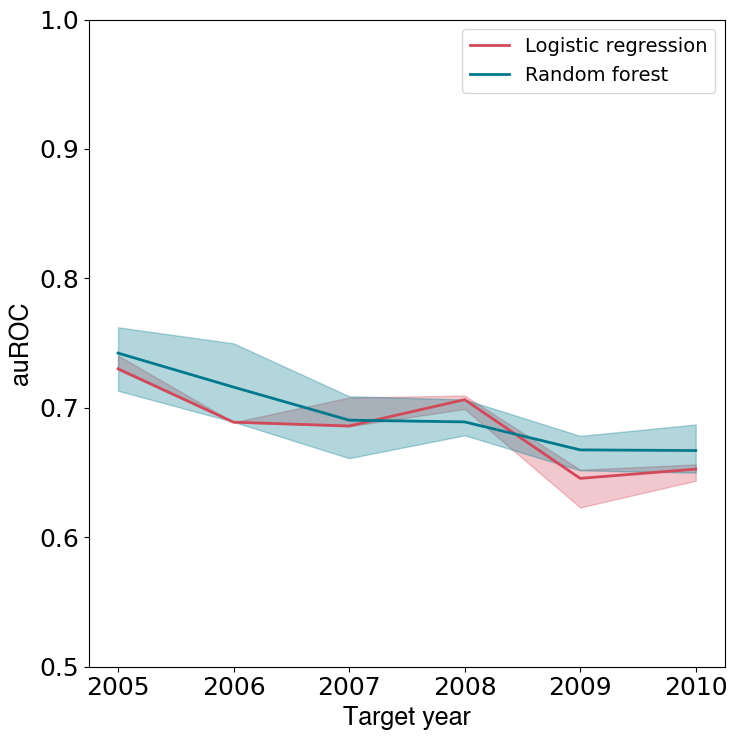

In [128]:
############# Graph 1: auROC by year 2005-2010, trained on previous 5 years' data, for nn, rf and lr with intervals
fig, axs = plt.subplots(figsize=(7.5, 7.5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
years = np.array(range(2005, 2011))
axs.tick_params(axis='both', which='major', labelsize=18)
axs.set_xticks(np.array(range(2005, 2011)))
#axs.set_xticks([2005, 2007, 2010])

#axs.plot(years, ROC_by_year[2].values(),linewidth = 2, label = "Neural network", color = "#edae49")
#axs.fill_between(years, lower_quartile_by_year[2].values(), upper_quartile_by_year[2].values(), color = "#edae49", alpha = 0.3)

axs.plot(years, ROC_by_year[0].values(),linewidth = 2, label = "Logistic regression", color = "#d1495b")
axs.fill_between(years, lower_quartile_by_year[0].values(), upper_quartile_by_year[0].values(), color = "#d1495b", alpha = 0.3)

axs.plot(years, ROC_by_year[1].values(),linewidth = 2, label = "Random forest", color = "#00798c")
axs.fill_between(years, lower_quartile_by_year[1].values(), upper_quartile_by_year[1].values(), color = "#00798c", alpha = 0.3)

axs.set_ylabel("auROC", fontsize = 18, **hfont)
axs.set_xlabel("Target year",  fontsize = 18,**hfont)
axs.set_ylim([0.5,1])
axs.legend(prop={'size':14})
plt.tight_layout()


# SI Graphs

Senistivity and specificity

Functions for SI

In [130]:
def effective_unnecessary_threshold(
    threshold_seq, y_predict_proba, y_test, cipro_R_prevalence
):

    get_effective_threshold = []
    incorrectly_get_X_threshold = []  # no bootstrapping, no 95% CI
    sensitivity_threshold = []
    specificity_threshold = []
    for threshold in threshold_seq:

        y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

        tn_test, fp_test, fn_test, tp_test = confusion_matrix(
            y_true=y_test, y_pred=y_predict_test
        ).ravel()

        sensitivity_test = tp_test / (tp_test + fn_test)
        specificity_test = tn_test / (tn_test + fp_test)

        sensitivity_threshold.append(sensitivity_test * 100)
        specificity_threshold.append(specificity_test * 100)
        get_effective_threshold.append(
            sensitivity_test * cipro_R_prevalence * 100
            + (100 - cipro_R_prevalence * 100)
        )  # q_p
        incorrectly_get_X_threshold.append(
            (100 - cipro_R_prevalence * 100) * (1 - specificity_test)
        )  # c_p"
    return (
        sensitivity_threshold,
        specificity_threshold,
        get_effective_threshold,
        incorrectly_get_X_threshold,
    )

def bootstrap_sensitivity_specificity_preloaded(iterations,  y_test, actual_sensitivity, actual_specificity):
      #1. Find apparent model performance
    lower_quartile_specificity_all = []
    upper_quartile_specificity_all = []
    lower_quartile_sensitivity_all = []
    upper_quartile_sensitivity_all = []
    for threshold in threshold_seq:
      bootstrapped_stats = []

      for j in range(iterations):
            model_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) + ".sav" 
            X_data_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_X_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) + ".csv" 
            X_train_bootstrap = pd.read_csv(X_data_name)
            model_fit = pickle.load(open(model_name, 'rb'))
            X_test_for_bootstrap = test_data[X_train_bootstrap.columns[1:len(X_train_bootstrap.columns)]]
            #y_sample_predict = model_fit.predict(X_test)
            y_bootstrap_predict_prob = model_fit.predict_proba(X_test_for_bootstrap) #predicting it on the real data

            y_bootstrap_predict = np.where(y_bootstrap_predict_prob[:, 1] > threshold, 1, 0)

            tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_true=y_test, y_pred=y_bootstrap_predict).ravel()

            sensitivity_test = (tp_test / (tp_test + fn_test))*100
            specificity_test = (tn_test / (tn_test + fp_test))*100

          ### (D) Calculate estimate fo variance  by getting (B) - (D) 
            difference_sensitivity = sensitivity_test - actual_sensitivity[np.where(threshold_seq ==threshold)[0][0]] ## according to https://ocw.mit.edu/courses/18-05-introduction-to-probability-and-statistics-spring-2014/resources/mit18_05s14_reading24/
            difference_specificity = specificity_test - actual_specificity[np.where(threshold_seq ==threshold)[0][0]]  ## according to https://ocw.mit.edu/courses/18-05-introduction-to-probability-and-statistics-spring-2014/resources/mit18_05s14_reading24/


            bootstrapped_stats.append(
            {

                'Difference_specificity': difference_specificity, 
                'Difference_sensitivity': difference_sensitivity#,
            }
          )
      alpha = 0.05
      bootstrapped_stats = pd.DataFrame(bootstrapped_stats)

      upper_quartile_senstivity, lower_quartile_sensitivity = actual_sensitivity[np.where(threshold_seq ==threshold)[0][0]] - np.percentile(bootstrapped_stats["Difference_sensitivity"], [100 * (1 - alpha / 2.0), 100 * alpha / 2.0])
      upper_quartile_specificity, lower_quartile_specificity = actual_specificity[np.where(threshold_seq ==threshold)[0][0]] - np.percentile(bootstrapped_stats["Difference_specificity"], [100 * (1 - alpha / 2.0), 100 * alpha / 2.0])



      lower_quartile_specificity_all.append(lower_quartile_specificity)
      upper_quartile_specificity_all.append(upper_quartile_specificity)
      lower_quartile_sensitivity_all.append(lower_quartile_sensitivity)
      upper_quartile_sensitivity_all.append(upper_quartile_senstivity)
 ## Step 4: Get optimization-corrected performance

    return lower_quartile_specificity_all, upper_quartile_specificity_all,lower_quartile_sensitivity_all,upper_quartile_sensitivity_all



In [ ]:
CIP_data_no_drop = 

In [135]:
### RF Bootstrap sensitivity and specificity 
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
labels = ["A", "B", "C", "D", "E", "F" ]
years = [2005, 2006, 2007, 2008, 2009, 2010]
axs[0,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,1].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,2].set_xlabel('Threshold (p)', fontsize=18,**hfont)

axs[0,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)
axs[0,0].set_ylim(-10, 100)
axs[0,1].set_ylim(-10, 100)
axs[0,2].set_ylim(-10, 100)
axs[1,0].set_ylim(-10, 100)
axs[1,1].set_ylim(-10, 100)
axs[1,2].set_ylim(-10, 100)
axs = axs.ravel()

threshold_seq = np.linspace(0,1,501)
years = [2005, 2006, 2007, 2008, 2009, 2010]
i = 0
for year in years:
    model_type = 1
    years_train = np.array(range(year - 5, year))
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_rf[year],years_train = years_train, model_type = model_type)


    model_name = "CIP_rf_" + str(year) + ".sav" 
    model_fit_train = pickle.load(open(model_name, 'rb'))
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)

    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    lower_quartile_specificity, upper_quartile_specificity,lower_quartile_sensitivity,upper_quartile_sensitivity = bootstrap_sensitivity_specificity_preloaded(iterations,  y_test, sensitivity_threshold, specificity_threshold)

    #plot
    axs[i].plot(threshold_seq, sensitivity_threshold, color = "#c8b6ff", label = r"Sensitivity", linewidth = 2)
    axs[i].fill_between(threshold_seq, lower_quartile_sensitivity, upper_quartile_sensitivity, color = "#c8b6ff", alpha = 0.3)

    axs[i].plot(threshold_seq, specificity_threshold, color = "#99d98c", label = r"Specificity", linewidth = 2)
    axs[i].fill_between(threshold_seq, lower_quartile_specificity, upper_quartile_specificity, color = "#99d98c", alpha = 0.3)
    axs[i].set_title(year,fontsize=20)

    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1
axs[0].legend()
plt.tight_layout()

plt.savefig("Graphs/Sensitivity_specificity_all_workflow_paper_random_forest_2005_2010_bootstrap_weights_extra_features.png", dpi = 300)

Oversample


In [ ]:
### LR Bootstrap sensitivity and specificity 
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
labels = ["A", "B", "C", "D", "E", "F" ]
years = [2005, 2006, 2007, 2008, 2009, 2010]
axs[0,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,1].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,2].set_xlabel('Threshold (p)', fontsize=18,**hfont)

axs[0,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[0,0].set_ylim(-10, 100)
axs[0,1].set_ylim(-10, 100)
axs[0,2].set_ylim(-10, 100)
axs[1,0].set_ylim(-10, 100)
axs[1,1].set_ylim(-10, 100)
axs[1,2].set_ylim(-10, 100)
axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)
axs = axs.ravel()

threshold_seq = np.linspace(0,1,501)

i = 0
for year in years:
    model_type = 0
    years_train = np.array(range(year - 5, year))
    important_features = best_features_by_year[model_type][year]
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = 0)

    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters_by_year[model_type][year]['solver'], C = best_hyperparameters_by_year[model_type][year]['C'], penalty = best_hyperparameters_by_year[model_type][year]['penalty'])
    
    ## fit model
    model_name = "CIP_lr_" + str(year) + ".sav" 
    model_fit_train = pickle.load(open(model_name, 'rb'))
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    lower_quartile_specificity, upper_quartile_specificity,lower_quartile_sensitivity,upper_quartile_sensitivity = bootstrap_sensitivity_specificity_preloaded(iterations,  y_test, sensitivity_threshold, specificity_threshold)

    #plot
    axs[i].plot(threshold_seq, sensitivity_threshold, color = "#c8b6ff", label = r"Sensitivity", linewidth = 2)
    axs[i].fill_between(threshold_seq, lower_quartile_sensitivity, upper_quartile_sensitivity, color = "#c8b6ff", alpha = 0.3)

    axs[i].plot(threshold_seq, specificity_threshold, color = "#99d98c", label = r"Specificity", linewidth = 2)
    axs[i].fill_between(threshold_seq, lower_quartile_specificity, upper_quartile_specificity, color = "#99d98c", alpha = 0.3)
    axs[i].set_title(year,fontsize=20)

    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1
axs[0].legend()
plt.tight_layout()

plt.savefig("Graphs/Sensitivity_specificity_all_workflow_paper_logistic_regression_2005_2010_bootstrap_weights_extra_features.png", dpi = 300)